In [7]:
#import necessary modules
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

In [32]:
#load data 
load_data = np.load('all_train_data.npy', allow_pickle=True)
inten_df = pd.DataFrame(load_data)

# Create feature and target arrays
X = inten_df.drop(101300, axis=1) 
y = inten_df[101300].astype('int') #last column is the modified or not modified feature

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4 , random_state=42)

In [33]:
# Instantiate a classifier
rfc = RandomForestClassifier()

# Fit the classifier to the training data
rfc.fit(X_train, y_train)

# Print the accuracy
print(rfc.score(X_test, y_test))

0.9411764705882353


In [35]:
print("Test set predictions: {}".format(rfc.predict(X_test)))
print("Test set accuracy: {:.2f}".format(rfc.score(X_test, y_test)))

Test set predictions: [1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0]
Test set accuracy: 0.94


In [34]:
#adjust parameters
rfc = RandomForestClassifier(max_depth=6, n_estimators=100)

#fit classifier
rfc.fit(X_train, y_train)

#predict using the X_test data
y_pred_rf = rfc.predict(X_test)

#build dataframe to house the scores.
df = pd.DataFrame()

#name columns
cols = ['Machine Learning Classification Method',
        'Train Accuracy', 
        'Test Accuracy']

#name required cells 
df.loc['Machine Learning Classification Method', 
       'Details'] = 'Random Forest Classifier'

#fit classifier onto both datasets to compare 
df.loc['Train Accuracy', 'Details'] = rfc.score(X_train, y_train) 
df.loc['Test Accuracy', 'Details'] = rfc.score(X_test, y_test)
print(df)

                                                         Details
Machine Learning Classification Method  Random Forest Classifier
Train Accuracy                                                 1
Test Accuracy                                           0.941176


Hypertuning parameters using RandomizedGridSearch as it would be too computationally exhausting to use GridSearchCV 

In [16]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(0, 50),
              "min_samples_leaf": randint(0, 50),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
rfc = RandomForestClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
rfc_cv = RandomizedSearchCV(rfc, param_dist, cv=5)

# Fit it to the data
rfc_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned RandomForest Parameters: {}".format(rfc_cv.best_params_))
print("Best score is {}".format(rfc_cv.best_score_))

Tuned RandomForest Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 37, 'min_samples_leaf': 7}
Best score is 0.836111111111111


Using the parameters "max_features": randint(0, 101300), "min_samples_leaf": randint(0, 101300) gave a best score of 0.5861. While the parameters "max_features": randint(0, 10), "min_samples_leaf": randint(0, 10) produced multiple fitfailed errors. TThe parameters "max_features": randint(0, 100), "min_samples_leaf": randint(0, 100) however produced a best score of 0.903

In [21]:
#fit the classifier to the training data
rfc.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = rfc.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[10  0]
 [ 1  6]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.86      0.92         7

    accuracy                           0.94        17
   macro avg       0.95      0.93      0.94        17
weighted avg       0.95      0.94      0.94        17



In [22]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('knn', RandomForestClassifier())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training set: knn_scaled
rfc_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
rfc_unscaled = rfc.fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(rfc_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(rfc_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.9411764705882353
Accuracy without Scaling: 0.9411764705882353


Comparable results across all metrics to desiciontree, this was expected given random forests are built on decision trees.

## PCA

It was determined by running the script plotting the number of PC's that the maximum number of PC's was 24 and thus this was set as the maximum in its parameters

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [25]:
#build the pipeline
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=16)),
        ('classifier', RandomForestClassifier())])

#fit the pipeline to the training data
pipe.fit(X_train, y_train)

#score the accuracy on the test set
accuracy = pipe.score(X_test, y_test)

#prints the explained variance ratio and accuracy
print(pipe.steps[1][1].explained_variance_ratio_)
print('{0:.1%} test set accuracy'.format(accuracy))

[0.38292233 0.18447505 0.06563357 0.06000496 0.04557259 0.03904013
 0.03684829 0.03620122 0.02944592 0.02576071 0.02346922 0.02139708
 0.01971206 0.01481332 0.00799426 0.00485559]
88.2% test set accuracy


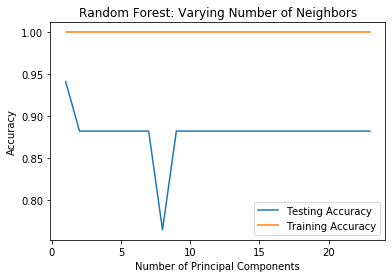

In [36]:
# Setup arrays to store train and test accuracies
n_components = np.arange(1, 24)
train_accuracy = np.empty(len(n_components))
test_accuracy = np.empty(len(n_components))

# Loop over different values of k
for i, k in enumerate(n_components):
    
    #setup a pipeline with a k-NN Classifier with k neighbors: knn
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=k)),
        ('classifier', RandomForestClassifier())])

    #fit the pipeline to to the training data
    pipe.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = pipe.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = pipe.score(X_test, y_test)

# Generate plot
plt.title('Random Forest: Varying Number of Neighbors')
plt.plot(n_components, test_accuracy, label = 'Testing Accuracy')
plt.plot(n_components, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.show()

Using principal components with the random forest classifier seems to perform better than principal components with decision tree classifier. 